In [3]:
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import splitfolders
import random
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn
from torch.optim import Adam
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

## Import 

In [3]:
splitfolders.ratio("/Users/HPPPPP/Downloads/sugar_cane_disease",
            output="splitted_data",
            seed=42,
            ratio=(.6, .2, .2),
            group_prefix=None,
            move=False)

Copying files: 2521 files [03:34, 11.75 files/s]


In [4]:
img_size=224
# Transformations
transform_train=transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(),
    transforms.GaussianBlur(kernel_size=(3, 7), sigma=(0.1, 2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

transform=transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

# Load Dataset
train_dataset=datasets.ImageFolder(root="/Users/HPPPPP/Downloads/Deep_learn_data/splitted_data/train",transform=transform_train)
val_dataset=datasets.ImageFolder(root="/Users/HPPPPP/Downloads/Deep_learn_data/splitted_data/val",transform=transform)
test_dataset=datasets.ImageFolder(root="/Users/HPPPPP/Downloads/Deep_learn_data/splitted_data/test",transform=transform)

# Data Loader
batch_size=15
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

# 5. Verify Class Mapping & Sizes
# -----------------------------
print(f"Classes: {train_dataset.classes}")
print(f"Train samples: {len(train_dataset)} | Val samples: {len(val_dataset)} | Test samples: {len(test_dataset)}")


Classes: ['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']
Train samples: 1563 | Val samples: 554 | Test samples: 508


## Explore

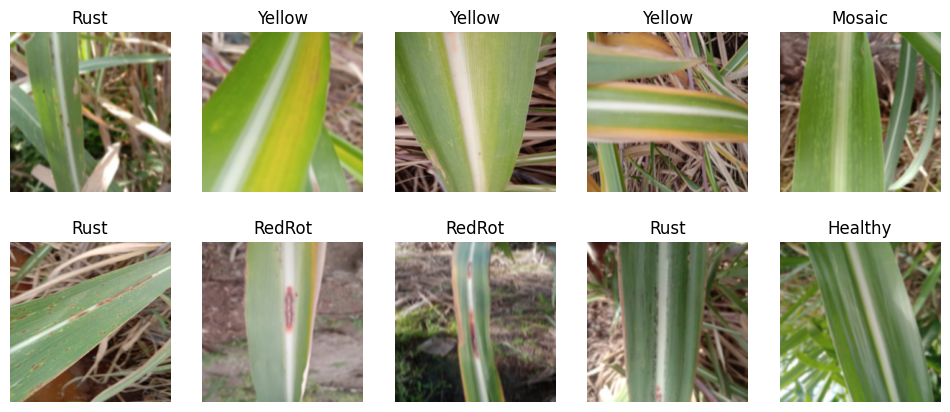

In [5]:
# Visualization (unnormalise for display)

def unnormalise(inp,title=None,ax=None):
     """Display a tensor image after unnormalizing (ImageNet stats)."""
     inp=inp.numpy().transpose((1,2,0))
     mean=np.array([0.485,0.456,0.406])
     std=np.array([0.229,0.224,0.225])
     inp=std*inp+mean
     inp=np.clip(inp,0,1)
     plt.imshow(inp)
     if ax is None:
        plt.imshow(inp)
     else:
        ax.imshow(inp)
        
     if title is not None:
        if ax is None:
            plt.title(title)
        else:
            ax.set_title(title)
    
     if ax is not None:
        ax.axis("off")
     else:
        plt.axis("off")

# show first 10 training images
image,label=next(iter(train_loader))
fig=plt.figure(figsize=(12,5))
for i in range(10):
     ax=fig.add_subplot(2,5,i+1)
     unnormalise(image[i], title=train_dataset.classes[label[i]], ax=ax)
plt.show()   
     

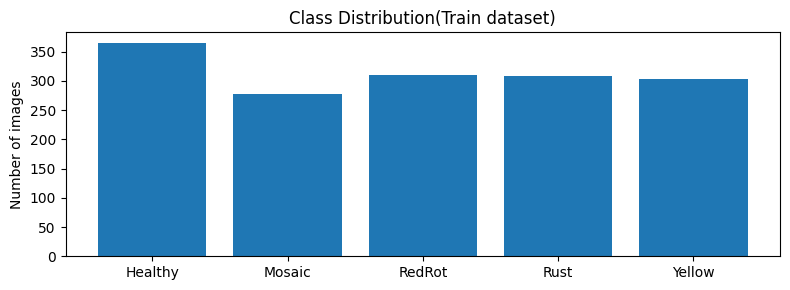

In [6]:
import collections
# Count samples per class
class_counts=collections.Counter([label for _,label in train_dataset.samples])

counts=[ class_counts[i] for i in range(len(train_dataset.classes))]

plt.figure(figsize=(8,3))
plt.bar(train_dataset.classes,counts)
plt.ylabel("Number of images")
plt.title("Class Distribution(Train dataset)")
plt.tight_layout()
plt.show()

## Deep Model

We will be using a pre-trained model called ResNet-18.Transfer learning is a process of utilizing pre-trained machine learning models and applying them to a related task without need of models' learning from scratch for saving time and possibly better performance.


In [7]:
import torch
import torch.nn as nn
from torchvision import models

# Load Pre-trained EfficientNet-B0
efficientnet = models.efficientnet_b0(weights='IMAGENET1K_V1')  # Auto-downloads weights

# Freeze Backbone
for param in efficientnet.parameters():
    param.requires_grad = False

# Modify final layer (EfficientNet uses 'classifier' instead of 'fc')
num_classes = len(train_dataset.classes)
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, num_classes)

model = efficientnet.to(device)

# Count trainable parameters (should be small)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters (classifier head only): {trainable_params:,}")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\HPPPPP/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:29<00:00, 726kB/s] 


Trainable parameters (classifier head only): 6,405


In [ ]:
import torch.optim as optim
import copy
import time
from tqdm import tqdm
import torch.nn as nn

# Loss Function
criterion=nn.CrossEntropyLoss()
# Optimizer
optimizer=optim.Adam(model.parameters(),lr=0.001)
# Decays LR by factor of 0.1 every 7 epochs
scheduler=optim.lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

def train_val_model(model,criterion,optimizer,scheduler,train_loader,val_loader,num_epochs=5,device="cpu"):
    best_model_weight=copy.deepcopy(model.state_dict())
    best_loss=float("inf")

    history={"train_loss":[],"train_acc":[],"val_loss":[],"val_acc":[]}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-"*20)

        for phase in ["train","val"]:
            if phase=="train":
                model.train()
                loader=train_loader
            else:
                model.eval()
                loader=val_loader
            running_loss=0.0
            running_correct=0
            total_samples=0

            for images,labels in loader:
                images,labels=images.to(device),labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=="train"):
                    output=model(images)
                    loss=criterion(output,labels)

                    if phase=="train":
                        loss.backward()
                        optimizer.step()
                # stat 
                running_loss+= loss.item()*images.size(0)
                running_correct+= (output.argmax(1)==labels).sum().item()
                total_samples+=labels.size(0)

            epoch_loss=running_loss/total_samples
            epoch_acc=running_correct/total_samples

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc)   

            # Track best model (lowest val loss)
            if phase=="val" and epoch_loss<best_loss:
                best_loss=epoch_loss
                best_model_weight=copy.deepcopy(model.state_dict())
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        scheduler.step()
        print()
    print(f'Best val loss: {best_loss:.4f}')
    # Load best weight
    model.load_state_dict(best_model_weight)

    return model,history
# Train the model
model, history_transfer = train_val_model(
        model, criterion, optimizer, scheduler,
        train_loader, val_loader,
        num_epochs=10, device='cpu')

#torch.save(model.state_dict(), "resnet18_mine_student.pth")




In [ ]:
#Save and Load Model
torch.save(model.state_dict(), "resnet18_mine_student.pth")
model.load_state_dict(torch.load("resnet18_mine_student.pth",map_location="cpu"))

In [ ]:
# Visualize Training and Validation train model
epochs=range(1,len(history_transfer["train_loss"])+1)

# Loss Plot

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs,history_transfer["train_loss"],label="Train_loss")
plt.plot(epochs,history_transfer["val_loss"],label="Val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation loss")
plt.grid(True,linestyle="--",linewidth=0.5)
plt.legend()

# Accuracy Plot
plt.subplot(1,2,2)
plt.plot(epochs,history_transfer["train_acc"],label="Train_acc")
plt.plot(epochs,history_transfer["val_acc"],label="Val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation accuracy")
plt.grid(True,linestyle="--",linewidth=0.5)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.eval()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
def evaluate_model(model,loader,device="cpu"):
    model.eval()
    all_labels,all_preds=[],[]
    with torch.no_grad():
        for images,labels in loader:
            images,labels=images.to(device),labels.to(device)
            output=model(images)
            preds=output.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc=accuracy_score(all_labels,all_preds)  
    return acc,np.array(all_labels),np.array(all_preds)  

# Evaluate model
test_acc,y_true,y_pred=evaluate_model(model,test_loader,device="cpu")   
print(f"ResNet18 Transfer Learning Test Accuracy: {test_acc:.2%}")